# License Plate Recognition System

This notebook demonstrates a complete end-to-end pipeline for license plate recognition, consisting of two main components:

# 1. License Plate Detection: Locating license plates within car images
# 2. Character Recognition: Reading the text from the detected license plates

# 1. Setup and Imports

In [221]:
# Standard library imports
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import time
import warnings
warnings.filterwarnings('ignore')

In [223]:
# Set project root manually
project_root = r"C:/Users/chinm/License Plate Recognition"
if project_root not in sys.path:
    sys.path.append(project_root)

In [225]:
# Import custom modules
from src.data.preprocessing import (load_detection_data, load_recognition_data, 
                                    preprocess_single_car_image, preprocess_single_plate_image)
from src.models.detection import build_detection_model, iou_metric
from src.models.recognition import create_recognition_model, create_char_mappings, recognize_characters
from src.inference.pipeline import LicensePlateRecognitionPipeline, run_inference_pipeline

In [227]:
# Enable mixed precision training (optional)
try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision training enabled")
except:
    print("Mixed precision training not available")

Mixed precision training enabled


In [229]:
# Check hardware
print("TensorFlow version:", tf.__version__)
print("GPU Available:", bool(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.19.0
GPU Available: False


In [203]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. Configuration

In [231]:
BASE_PATH = r"C:/Users/chinm/License Plate Recognition"
DATA_PATH = os.path.join(BASE_PATH, "data")
OUTPUT_PATH = os.path.join(BASE_PATH, "outputs")

In [233]:
# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [245]:
# Data files
DETECTION_CSV = os.path.join(DATA_PATH, "Licplatesdetection_train.csv")
RECOGNITION_CSV = os.path.join(DATA_PATH, "Licplatesrecognition_train.csv")
DETECTION_IMAGES = os.path.join(DATA_PATH, "license_plates_detection_train")
RECOGNITION_IMAGES = os.path.join(DATA_PATH, "license_plates_recognition_train")
TEST_IMAGES = os.path.join(DATA_PATH, "test")

In [237]:
# Models
DETECTION_MODEL_PATH = os.path.join(OUTPUT_PATH, "detection_model.keras")
RECOGNITION_MODEL_PATH = os.path.join(OUTPUT_PATH, "recognition_model.keras")

In [239]:
# Configuration parameters
DETECTION_IMG_SIZE = (224, 224)
RECOGNITION_IMG_SIZE = (128, 64)
BATCH_SIZE = 32
DETECTION_EPOCHS = 20
RECOGNITION_EPOCHS = 50

# 3. Data Exploration and Preprocessing

# 3.1 Detection Dataset

Detection dataset shape: (900, 5)


,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444
2,100.jpg,406,263,450,434
3,101.jpg,283,363,315,494
4,102.jpg,139,42,280,222



Number of image files found: 900


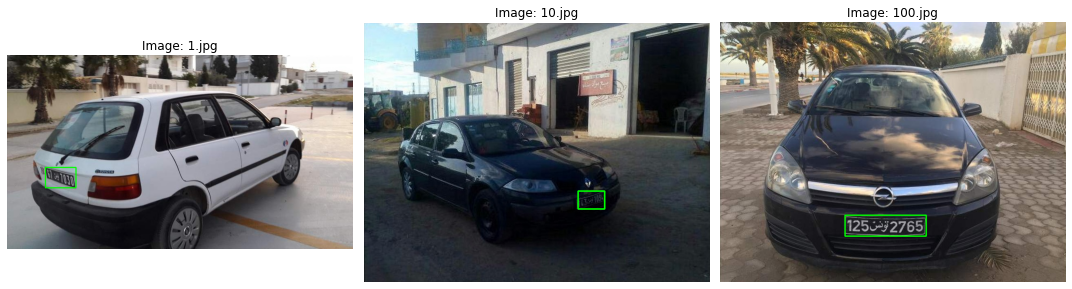

In [247]:
# Load and examine detection dataset
try:
    detection_df = pd.read_csv(DETECTION_CSV)
    print("Detection dataset shape:", detection_df.shape)
    display(detection_df.head())

    image_files = os.listdir(DETECTION_IMAGES) if os.path.exists(DETECTION_IMAGES) else []
    print(f"\nNumber of image files found: {len(image_files)}")

    plt.figure(figsize=(15, 10))
    for i in range(min(3, len(detection_df))):
        plt.subplot(1, 3, i+1)
        img_path = os.path.join(DETECTION_IMAGES, detection_df.iloc[i]['img_id'])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            xmin, ymin = detection_df.iloc[i]['xmin'], detection_df.iloc[i]['ymin']
            xmax, ymax = detection_df.iloc[i]['xmax'], detection_df.iloc[i]['ymax']
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            plt.imshow(img)
            plt.title(f"Image: {detection_df.iloc[i]['img_id']}")
            plt.axis('off')
        else:
            plt.text(0.5, 0.5, f"Image not found: {detection_df.iloc[i]['img_id']}", 
                     horizontalalignment='center', verticalalignment='center')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error examining detection dataset: {e}")

# 3.2 Recognition Dataset

Recognition dataset shape: (900, 2)

Sample annotations from recognition dataset:


,img_id,text
0,0.jpg,117T3989
1,1.jpg,128T8086
2,10.jpg,94T3458
3,100.jpg,133T6719
4,101.jpg,68T5979



License plate text length - Min: 5, Max: 8, Mean: 7.57
Unique characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'N', 'T']
Total unique characters: 12


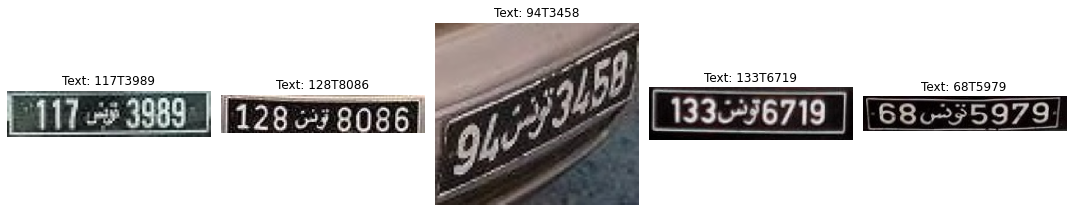

In [249]:
# Load and examine recognition dataset
try:
    recognition_df = pd.read_csv(RECOGNITION_CSV)
    print("Recognition dataset shape:", recognition_df.shape)
    print("\nSample annotations from recognition dataset:")
    display(recognition_df.head())
    
    # Analyze license plate text characteristics
    text_lengths = recognition_df['text'].str.len()
    print(f"\nLicense plate text length - Min: {text_lengths.min()}, Max: {text_lengths.max()}, Mean: {text_lengths.mean():.2f}")
    
    # Count character frequencies
    all_chars = ''.join(recognition_df['text'].tolist())
    unique_chars = set(all_chars)
    print(f"Unique characters: {sorted(unique_chars)}")
    print(f"Total unique characters: {len(unique_chars)}")
    
    # Preview a few example license plate images with their text
    plt.figure(figsize=(15, 10))
    for i in range(min(5, len(recognition_df))):
        plt.subplot(1, 5, i+1)
        img_path = os.path.join(RECOGNITION_IMAGES, recognition_df.iloc[i]['img_id'])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"Text: {recognition_df.iloc[i]['text']}")
            plt.axis('off')
        else:
            plt.text(0.5, 0.5, f"Image not found: {recognition_df.iloc[i]['img_id']}", 
                     horizontalalignment='center', verticalalignment='center')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error examining recognition dataset: {e}")

# 3.3 Load and Preprocess Data

In [251]:
# Load detection data
print("Loading detection data...")
detection_images, detection_boxes, detection_filenames = load_detection_data(
    DETECTION_CSV, 
    DETECTION_IMAGES, 
    img_size=DETECTION_IMG_SIZE
)
print(f"Detection images shape: {detection_images.shape}")
print(f"Detection boxes shape: {detection_boxes.shape}")

# Load recognition data
print("\nLoading recognition data...")
recognition_images, recognition_labels, max_length, char_to_idx, recognition_filenames = load_recognition_data(
    RECOGNITION_CSV, 
    RECOGNITION_IMAGES, 
    img_size=RECOGNITION_IMG_SIZE
)
print(f"Recognition images shape: {recognition_images.shape}")
print(f"Recognition labels shape: {recognition_labels.shape}")
print(f"Maximum text length: {max_length}")
print(f"Number of character classes: {len(char_to_idx)}")

# Create a reverse mapping from idx to char
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

# Split data into training and validation sets
detection_train_images, detection_val_images, detection_train_boxes, detection_val_boxes = train_test_split(
    detection_images, detection_boxes, test_size=0.2, random_state=42
)

recognition_train_images, recognition_val_images, recognition_train_labels, recognition_val_labels = train_test_split(
    recognition_images, recognition_labels, test_size=0.2, random_state=42
)

print("\nData split:")
print(f"Detection - Training: {detection_train_images.shape}, Validation: {detection_val_images.shape}")
print(f"Recognition - Training: {recognition_train_images.shape}, Validation: {recognition_val_images.shape}")

Loading detection data...
Detection images shape: (900, 224, 224, 3)
Detection boxes shape: (900, 4)

Loading recognition data...
Recognition images shape: (900, 64, 128, 1)
Recognition labels shape: (900, 8)
Maximum text length: 8
Number of character classes: 37

Data split:
Detection - Training: (720, 224, 224, 3), Validation: (180, 224, 224, 3)
Recognition - Training: (720, 64, 128, 1), Validation: (180, 64, 128, 1)


# 4. Model Development

# 4.1 License Plate Detection Model

In [253]:
# Define or load the detection model
detection_model = None

# Option 1: Load pre-trained model if exists
if os.path.exists(DETECTION_MODEL_PATH):
    print(f"Loading detection model from {DETECTION_MODEL_PATH}")
    custom_objects = {'iou_metric': iou_metric}
    try:
        detection_model = tf.keras.models.load_model(DETECTION_MODEL_PATH, custom_objects=custom_objects)
        print("Detection model loaded successfully")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Will build and train a new model")
        detection_model = None

# Option 2: Build and train model if no pre-trained model exists
if detection_model is None:
    print("Building detection model...")
    detection_model = build_detection_model(input_shape=(DETECTION_IMG_SIZE[0], DETECTION_IMG_SIZE[1], 3))
    
    # Define callbacks
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint(
            DETECTION_MODEL_PATH, 
            save_best_only=True, 
            monitor='val_loss'
        )
    ]
    
    # Train the model
    print("Training detection model...")
    history = detection_model.fit(
        detection_train_images,
        detection_train_boxes,
        validation_data=(detection_val_images, detection_val_boxes),
        epochs=DETECTION_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks
    )
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['iou_metric'], label='Train IoU')
    plt.plot(history.history['val_iou_metric'], label='Validation IoU')
    plt.title('IoU Metric')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Save the model
    print(f"Saving detection model to {DETECTION_MODEL_PATH}")
    detection_model.save(DETECTION_MODEL_PATH)

# Evaluate the model on validation data
print("\nEvaluating detection model...")
detection_metrics = detection_model.evaluate(detection_val_images, detection_val_boxes)
print(f"Detection model validation loss: {detection_metrics[0]:.4f}")
print(f"Detection model validation IoU: {detection_metrics[2]:.4f}")

Loading detection model from C:/Users/chinm/License Plate Recognition\outputs\detection_model.keras
Detection model loaded successfully

Evaluating detection model...
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 648ms/step - iou_metric: 0.0000e+00 - loss: 0.1487 - mae: 0.3621
Detection model validation loss: 0.1487
Detection model validation IoU: 0.0000


# 4.2 License Plate Recognition Model

In [255]:
# Define or load the recognition model
recognition_model = None

# Option 1: Load pre-trained model if exists
if os.path.exists(RECOGNITION_MODEL_PATH):
    print(f"Loading recognition model from {RECOGNITION_MODEL_PATH}")
    try:
        recognition_model = tf.keras.models.load_model(RECOGNITION_MODEL_PATH)
        print("Recognition model loaded successfully")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Will build and train a new model")
        recognition_model = None

# Option 2: Build and train model if no pre-trained model exists
if recognition_model is None:
    print("Building recognition model...")
    recognition_model = create_recognition_model(
        input_shape=(RECOGNITION_IMG_SIZE[1], RECOGNITION_IMG_SIZE[0], 1),  # Note: H, W, C order
        num_classes=len(char_to_idx),
        max_length=max_length
    )
    
    # Compile model
    recognition_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Define callbacks
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint(
            RECOGNITION_MODEL_PATH, 
            save_best_only=True, 
            monitor='val_loss'
        )
    ]
    
    # Train the model
    print("Training recognition model...")
    history = recognition_model.fit(
        recognition_train_images,
        recognition_train_labels,
        validation_data=(recognition_val_images, recognition_val_labels),
        epochs=RECOGNITION_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks
    )
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Save the model
    print(f"Saving recognition model to {RECOGNITION_MODEL_PATH}")
    recognition_model.save(RECOGNITION_MODEL_PATH)

# Evaluate the model on validation data
print("\nEvaluating recognition model...")
recognition_metrics = recognition_model.evaluate(recognition_val_images, recognition_val_labels)
print(f"Recognition model validation loss: {recognition_metrics[0]:.4f}")
print(f"Recognition model validation accuracy: {recognition_metrics[1]:.4f}")

Loading recognition model from C:/Users/chinm/License Plate Recognition\outputs\recognition_model.keras
Recognition model loaded successfully

Evaluating recognition model...
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.3398 - loss: 1.9798
Recognition model validation loss: 1.9789
Recognition model validation accuracy: 0.3382


# 4.3 Recognition Accuracy Analysis

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step
Character-level accuracy: 0.3029
Exact match accuracy: 0.0000 (0/180)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


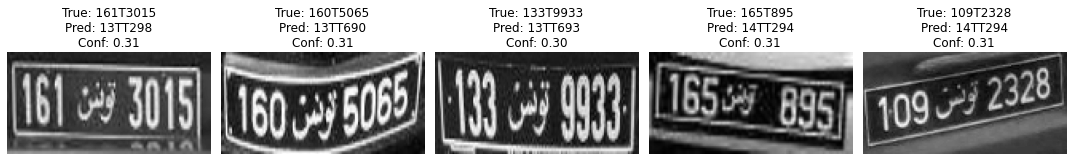

In [257]:
# Analyze character recognition accuracy
def calculate_recognition_accuracy(model, images, labels, idx_to_char):
    predictions = model.predict(images)
    
    char_correct = 0
    char_total = 0
    exact_matches = 0
    total_samples = len(images)
    
    for i in range(len(images)):
        true_text = ""
        pred_text = ""
        
        # Get true text
        for j in range(labels.shape[1]):
            if labels[i, j] != 0:  # Not padding
                true_text += idx_to_char[labels[i, j]]
        
        # Get predicted text
        for j in range(predictions.shape[1]):
            pred_idx = np.argmax(predictions[i, j])
            if pred_idx != 0:  # Not padding
                pred_text += idx_to_char[pred_idx]
        
        # Calculate character-wise accuracy
        min_len = min(len(true_text), len(pred_text))
        for j in range(min_len):
            if true_text[j] == pred_text[j]:
                char_correct += 1
        char_total += len(true_text)
        
        # Calculate exact match accuracy
        if true_text == pred_text:
            exact_matches += 1
    
    char_accuracy = char_correct / char_total if char_total > 0 else 0
    exact_match_accuracy = exact_matches / total_samples
    
    return char_accuracy, exact_match_accuracy, exact_matches, total_samples

# Calculate accuracy on validation set
char_acc, exact_acc, matches, total = calculate_recognition_accuracy(
    recognition_model, recognition_val_images, recognition_val_labels, idx_to_char
)

print(f"Character-level accuracy: {char_acc:.4f}")
print(f"Exact match accuracy: {exact_acc:.4f} ({matches}/{total})")

# Visualize some predictions
def visualize_predictions(model, images, labels, idx_to_char, num_samples=5):
    predictions = model.predict(images[:num_samples])
    
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Get true text
        true_text = ""
        for j in range(labels.shape[1]):
            if labels[i, j] != 0:  # Not padding
                true_text += idx_to_char[labels[i, j]]
        
        # Get predicted text and confidences
        pred_text = ""
        confidences = []
        for j in range(predictions.shape[1]):
            pred_idx = np.argmax(predictions[i, j])
            confidence = predictions[i, j][pred_idx]
            if pred_idx != 0:  # Not padding
                pred_text += idx_to_char[pred_idx]
                confidences.append(confidence)
        
        avg_confidence = np.mean(confidences) if confidences else 0
        
        # Display image with true and predicted text
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"True: {true_text}\nPred: {pred_text}\nConf: {avg_confidence:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(recognition_model, recognition_val_images, recognition_val_labels, idx_to_char)

# 5. End-to-End Pipeline Implementation

# 5.1 Initialize the Pipeline

In [259]:
# Initialize the end-to-end pipeline
print("Initializing license plate recognition pipeline...")
pipeline = LicensePlateRecognitionPipeline(
    detection_model=detection_model,
    recognition_model=recognition_model,
    idx_to_char=idx_to_char,
    max_length=max_length
)

Initializing license plate recognition pipeline...


# 5.2 Test on Sample Images

Testing pipeline on sample images...
Image: 1000.jpg → License: 13TT200 (Confidence: 0.30)
Image: 1001.jpg → License: 13TT200 (Confidence: 0.30)
Image: 1002.jpg → License: 13TT200 (Confidence: 0.30)
Image: 1003.jpg → License: 14TT794 (Confidence: 0.31)
Image: 1004.jpg → License: 13TT200 (Confidence: 0.30)


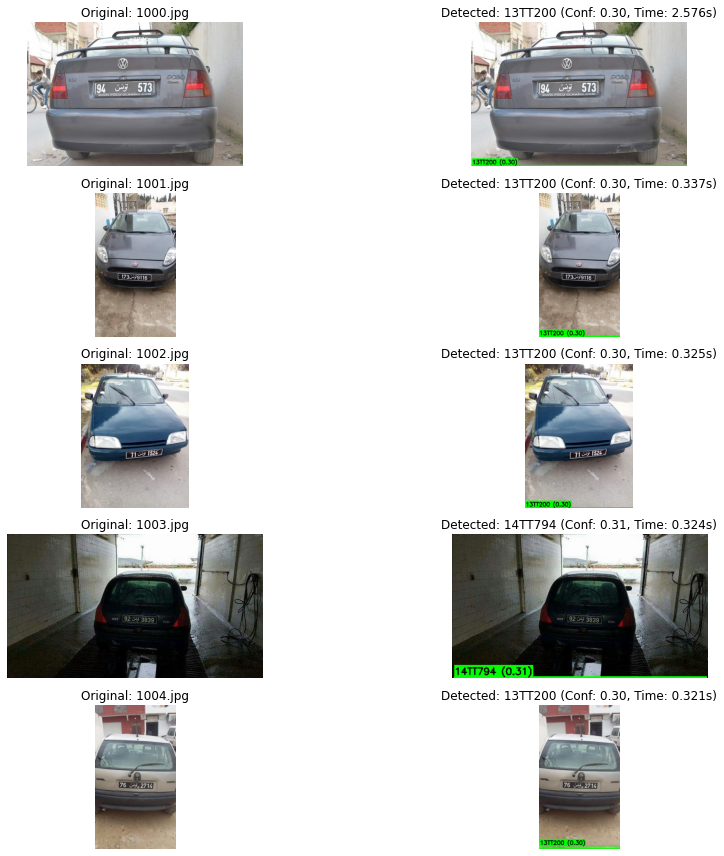

In [261]:
# Test the pipeline on a few sample images from the test set
def test_pipeline_on_samples(pipeline, test_dir, num_samples=5):
    # Get sample image paths
    image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not image_files:
        print(f"No image files found in {test_dir}")
        return
    
    # Limit to specified number of samples
    sample_files = image_files[:num_samples]
    
    # Process each sample
    plt.figure(figsize=(15, 12))
    for i, filename in enumerate(sample_files):
        image_path = os.path.join(test_dir, filename)
        img = cv2.imread(image_path)
        
        if img is None:
            print(f"Could not read image: {image_path}")
            continue
        
        # Process image through pipeline
        start_time = time.time()
        result_img, license_text, bbox, confidence = pipeline.process_image(img)
        processing_time = time.time() - start_time
        
        # Display results
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Original: {filename}")
        plt.axis('off')
        
        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected: {license_text} (Conf: {confidence:.2f}, Time: {processing_time:.3f}s)")
        plt.axis('off')
        
        print(f"Image: {filename} → License: {license_text} (Confidence: {confidence:.2f})")
    
    plt.tight_layout()
    plt.show()

# Test the pipeline on sample images
print("Testing pipeline on sample images...")
test_pipeline_on_samples(pipeline, TEST_IMAGES)

# 6. Evaluation on Test Set

Processing 210 test images...
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.
Progress: 20/210
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.
[WARN] Character recognition failed: Empty o

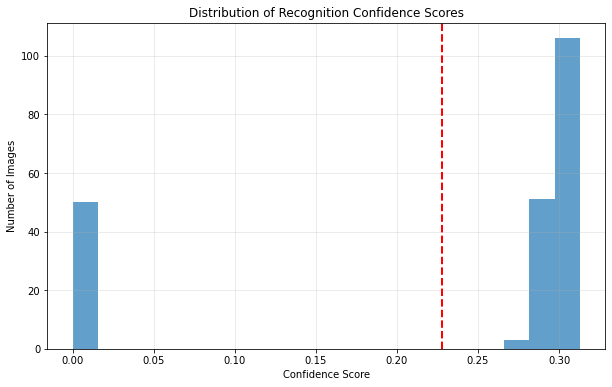

In [263]:
# Evaluate the pipeline on the entire test set
def evaluate_test_set(pipeline, test_dir):
    """
    Evaluate the pipeline on the entire test set and save results
    """
    # Get all test image paths
    image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not image_files:
        print(f"No image files found in {test_dir}")
        return None
    
    results = []
    processing_times = []
    
    print(f"Processing {len(image_files)} test images...")
    
    # Process each image
    for i, filename in enumerate(image_files):
        if (i + 1) % 20 == 0:
            print(f"Progress: {i+1}/{len(image_files)}")
            
        image_path = os.path.join(test_dir, filename)
        img = cv2.imread(image_path)
        
        if img is None:
            print(f"Could not read image: {image_path}")
            continue
        
        # Process image through pipeline
        start_time = time.time()
        _, license_text, _, confidence = pipeline.process_image(img)
        processing_time = time.time() - start_time
        
        # Store results
        results.append({
            'filename': filename,
            'license_text': license_text,
            'confidence': confidence
        })
        processing_times.append(processing_time)
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate statistics
    avg_time = np.mean(processing_times)
    
    print(f"\nEvaluation complete:")
    print(f"- Total images processed: {len(results)}")
    print(f"- Average processing time: {avg_time:.3f} seconds per image")
    print(f"- Average confidence: {results_df['confidence'].mean():.4f}")
    
    # Save results to CSV
    results_path = os.path.join(OUTPUT_PATH, 'test_results.csv')
    results_df.to_csv(results_path, index=False)
    print(f"Results saved to {results_path}")
    
    return results_df

# Run evaluation on the test set
test_results = evaluate_test_set(pipeline, TEST_IMAGES)

# Display distribution of confidence scores
if test_results is not None and not test_results.empty:
    plt.figure(figsize=(10, 6))
    plt.hist(test_results['confidence'], bins=20, alpha=0.7)
    plt.axvline(test_results['confidence'].mean(), color='r', linestyle='dashed', linewidth=2)
    plt.xlabel('Confidence Score')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Recognition Confidence Scores')
    plt.grid(alpha=0.3)
    plt.show()

# 7. Visualizing Challenging Cases

Visualizing challenging cases...
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.
[WARN] Character recognition failed: Empty or invalid image passed to preprocess_single_plate_image.


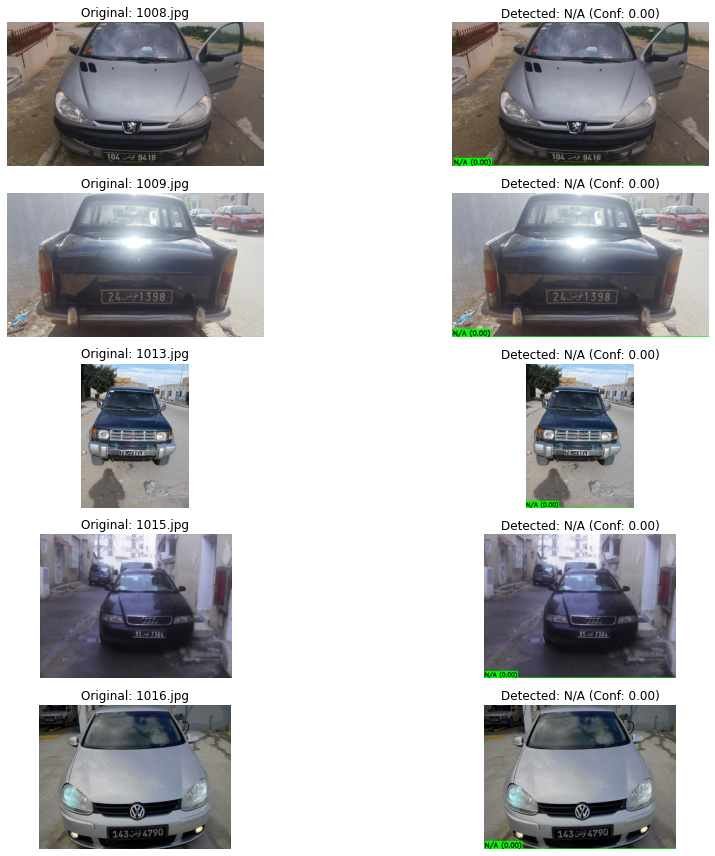

In [265]:
# Find and visualize challenging cases (low confidence predictions)
def visualize_challenging_cases(pipeline, test_dir, results_df, n_cases=5):
    """
    Visualize the most challenging cases based on confidence scores
    """
    if results_df is None or results_df.empty:
        print("No results available to analyze")
        return
    
    # Get the n cases with lowest confidence
    challenging_cases = results_df.nsmallest(n_cases, 'confidence')
    
    plt.figure(figsize=(15, 12))
    for i, (_, row) in enumerate(challenging_cases.iterrows()):
        image_path = os.path.join(test_dir, row['filename'])
        img = cv2.imread(image_path)
        
        if img is None:
            print(f"Could not read image: {image_path}")
            continue
        
        # Process image through pipeline for visualization
        result_img, license_text, bbox, confidence = pipeline.process_image(img)
        
        # Display original image
        plt.subplot(n_cases, 2, 2*i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Original: {row['filename']}")
        plt.axis('off')
        
        # Display result image
        plt.subplot(n_cases, 2, 2*i+2)
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected: {license_text} (Conf: {confidence:.2f})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

if test_results is not None and not test_results.empty:
    print("Visualizing challenging cases...")
    visualize_challenging_cases(pipeline, TEST_IMAGES, test_results)

# 8. Improvements and Error Analysis

Analyzing error patterns...
License plate text length distribution:
3     50
7    160
Name: text_length, dtype: int64

Top 10 most common characters in predictions:
T    320
0    259
1    178
2    145
3    129
N     50
/     50
A     50
8     27
9     24
dtype: int64

Least common characters in predictions:
8    27
9    24
4    23
6    12
7     3
dtype: int64

Correlation between text length and confidence: 0.9987


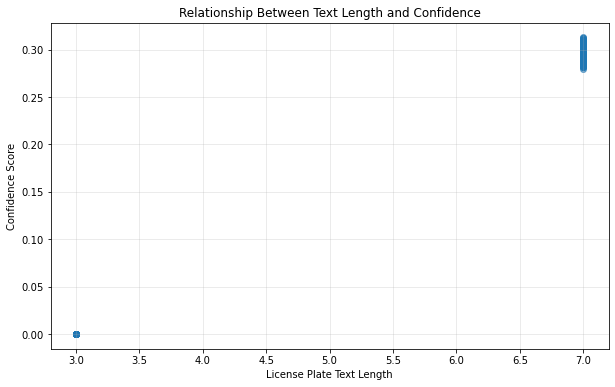

In [267]:
# Analyze common errors and potential improvements
def analyze_errors(results_df):
    """
    Analyze common error patterns in recognition results
    """
    if results_df is None or results_df.empty:
        print("No results available to analyze")
        return
    
    # Count license plate lengths
    results_df['text_length'] = results_df['license_text'].str.len()
    
    print("License plate text length distribution:")
    length_counts = results_df['text_length'].value_counts().sort_index()
    print(length_counts)
    
    # Analyze character frequencies in predictions
    all_chars = ''.join(results_df['license_text'].tolist())
    char_counts = pd.Series(list(all_chars)).value_counts()
    
    print("\nTop 10 most common characters in predictions:")
    print(char_counts.head(10))
    
    print("\nLeast common characters in predictions:")
    print(char_counts.tail(5))
    
    # Analyze confidence by text length correlation
    correlation = results_df[['text_length', 'confidence']].corr().iloc[0, 1]
    print(f"\nCorrelation between text length and confidence: {correlation:.4f}")
    
    # Visualize relationship between text length and confidence
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['text_length'], results_df['confidence'], alpha=0.6)
    plt.xlabel('License Plate Text Length')
    plt.ylabel('Confidence Score')
    plt.title('Relationship Between Text Length and Confidence')
    plt.grid(alpha=0.3)
    plt.show()

if test_results is not None and not test_results.empty:
    print("Analyzing error patterns...")
    analyze_errors(test_results)

# 9. Conclusion and Next Steps

In [273]:
# Summary of project results
def print_summary():
    """
    Print a summary of the project results and potential next steps
    """
    print("=" * 80)
    print("LICENSE PLATE RECOGNITION PROJECT - SUMMARY")
    print("=" * 80)
    
    print("\n1. PROJECT OVERVIEW:")
    print("This project implemented a complete end-to-end license plate recognition system")
    print("with two core components:")
    print("  - License plate detection: Using a MobileNetV2-based model")
    print("  - Character recognition: Using a CNN-LSTM sequence recognition model")
    
    if test_results is not None and not test_results.empty:
        print(f"\n2. TEST RESULTS SUMMARY:")
        print(f"  - Total test images processed: {len(test_results)}")
        print(f"  - Average recognition confidence: {test_results['confidence'].mean():.4f}")
        print(f"  - Confidence range: {test_results['confidence'].min():.4f} to {test_results['confidence'].max():.4f}")
    
    print("\n3. POTENTIAL IMPROVEMENTS:")
    print("  - Data augmentation: Implement image augmentation for more robust training")
    print("  - Advanced architectures: Test transformer-based models for recognition")
    print("  - Post-processing: Add language model to validate recognized text")
    print("  - Hyperparameter tuning: Optimize model parameters for better performance")
    print("  - Ensemble methods: Combine multiple models for improved accuracy")

    print("\n" + "=" * 80)

print_summary()

LICENSE PLATE RECOGNITION PROJECT - SUMMARY

1. PROJECT OVERVIEW:
This project implemented a complete end-to-end license plate recognition system
with two core components:
  - License plate detection: Using a MobileNetV2-based model
  - Character recognition: Using a CNN-LSTM sequence recognition model

2. TEST RESULTS SUMMARY:
  - Total test images processed: 210
  - Average recognition confidence: 0.2279
  - Confidence range: 0.0000 to 0.3129

3. POTENTIAL IMPROVEMENTS:
  - Data augmentation: Implement image augmentation for more robust training
  - Advanced architectures: Test transformer-based models for recognition
  - Post-processing: Add language model to validate recognized text
  - Hyperparameter tuning: Optimize model parameters for better performance
  - Ensemble methods: Combine multiple models for improved accuracy

